# 量子ノイズとエラーの緩和

<Admonition type="note">
  Toshinari Itoko (28 June 2024), translated by Kifumi Numata
  
  元の講義のPDFは[こちら](https://ibm.box.com/shared/static/a0zgies7bh91hm2lwev9o0bfeybxc6n6.zip) です。日本語版の講義資料は[こちら](11_error_mitigation.pdf)です。コードはバージョンアップによって、今後動かなくなることがあります。

  *この実験を実行するためのおおよそのQPU時間は 1 分 40秒です。*

</Admonition>



## 1. はじめに

このレッスンでは、ノイズと、量子コンピューターでノイズを緩和する方法を検討します。まず、実際の量子コンピューターからのノイズプロファイルを使用するなどして、ノイズをシミュレートできるシミュレーターを使用して、ノイズの影響を調べます。次に、実際の量子コンピューターでの固有のノイズに移ります。ゼロノイズ外挿 (zero-noise extrapolation, ZNE) やゲート回転などの組み合わせによるエラー緩和の効果を見ていきます。

はじめに、いくつかのパッケージをロードします。


In [1]:
# !pip install qiskit qiskit_aer qiskit_ibm_runtime
# !pip install jupyter
# !pip install matplotlib pylatexenc

In [2]:
import qiskit

qiskit.__version__

'2.1.2'

In [3]:
import qiskit_aer

qiskit_aer.__version__

'0.17.1'

In [4]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.__version__

'0.41.1'

## 2. エラー緩和のないノイズのシミュレーション

Qiskit Aerは、量子コンピューティング用の古典シミュレーターです。理想的な実行だけでなく、ノイズを含めた量子回路の実行もシミュレートできます。このノートブックは、Qiskit Aerを使用してノイズありのシミュレーションを実行する方法を示します。

1. ノイズモデルを構築する
2. ノイズモデルでノイズありのsampler(シミュレーター)を構築する
3. ノイズありのサンプラーで量子回路を実行する


```
noise_model = NoiseModel()
...
noisy_sampler = Sampler(options={"backend_options": {"noise_model": noise_model}})
job = noisy_sampler.run([circuit])
```



### 2.1 テスト回路の構築

Xゲートを `d` 回 (`d`=0 ... 100) 繰り返す、1量子ビットの回路を考えます。このトイモデルでオブザーバブル `Z` を測定します。


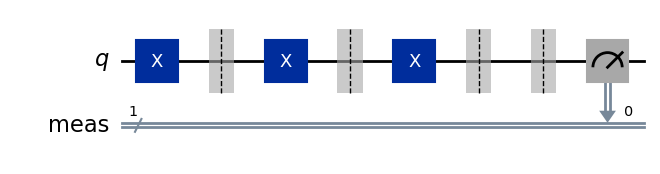

In [5]:
from qiskit.circuit import QuantumCircuit

MAX_DEPTH = 100
circuits = []
for d in range(MAX_DEPTH + 1):
    circ = QuantumCircuit(1)
    for _ in range(d):
        circ.x(0)
        circ.barrier(0)
    circ.measure_all()
    circuits.append(circ)

display(circuits[3].draw(output="mpl"))

In [6]:
from qiskit.quantum_info import SparsePauliOp

obs = SparsePauliOp.from_list([("Z", 1.0)])
obs

SparsePauliOp(['Z'],
              coeffs=[1.+0.j])

### 2.2 ノイズモデルの構築

ノイズありのシミュレーションを行うには、`NoiseModel` を指定する必要があります。このセクションでは、`NoiseModel` を構築する方法を示します。



まず、ノイズモデルに追加する量子(または読み出し)エラーを定義する必要があります。

In [7]:
from qiskit_aer.noise.errors import (
    coherent_unitary_error,
    amplitude_damping_error,
    ReadoutError,
)
from qiskit.circuit.library import RXGate

# コヒーレント(ユニタリー)エラー: X回転エラー
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.coherent_unitary_error.html#qiskit_aer.noise.coherent_unitary_error
OVER_ROTATION_ANGLE = 0.05
coherent_error = coherent_unitary_error(RXGate(OVER_ROTATION_ANGLE).to_matrix())

# インコヒーレントエラー: 振幅ダンピングエラー
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.amplitude_damping_error.html#qiskit_aer.noise.amplitude_damping_error
AMPLITUDE_DAMPING_PARAM = 0.02  # in [0, 1] (0: no error)
incoherent_error = amplitude_damping_error(AMPLITUDE_DAMPING_PARAM)

# 読み出し(測定)エラー: 読み出しエラー
# https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.noise.ReadoutError.html#qiskit_aer.noise.ReadoutError
PREP0_MEAS1 = 0.03  # P(1|0): 0を用意したが、1を測定してしまう確率
PREP1_MEAS0 = 0.08  # P(0|1): 1を用意したが、0を測定してしまう確率
readout_error = ReadoutError(
    [[1 - PREP0_MEAS1, PREP0_MEAS1], [PREP1_MEAS0, 1 - PREP1_MEAS0]]
)

In [8]:
from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel()
noise_model.add_quantum_error(coherent_error.compose(incoherent_error), "x", (0,))
noise_model.add_readout_error(readout_error, (0,))

### 2.3 ノイズモデルを使ったノイズありsamplerの構築


In [9]:
from qiskit_aer.primitives import SamplerV2 as Sampler

noisy_sampler = Sampler(options={"backend_options": {"noise_model": noise_model}})

### 2.4 ノイズありsamplerで量子回路を実行


In [10]:
job = noisy_sampler.run(circuits, shots=400)

In [11]:
result = job.result()

In [12]:
result[0].data.meas.get_counts()

{'0': 386, '1': 14}

### 2.5 結果の表示


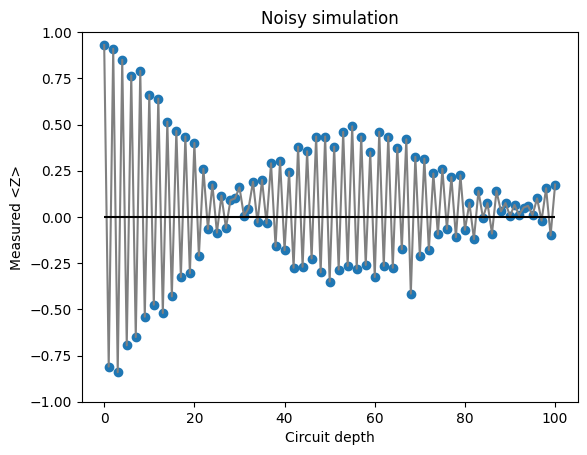

In [13]:
import matplotlib.pyplot as plt

plt.title("Noisy simulation")
ds = list(range(MAX_DEPTH + 1))
plt.plot(
    ds,
    [result[d].data.meas.expectation_values(["Z"]) for d in ds],
    color="gray",
    linestyle="-",
)
plt.scatter(ds, [result[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o")
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

### 2.6 理想的なシミュレーション



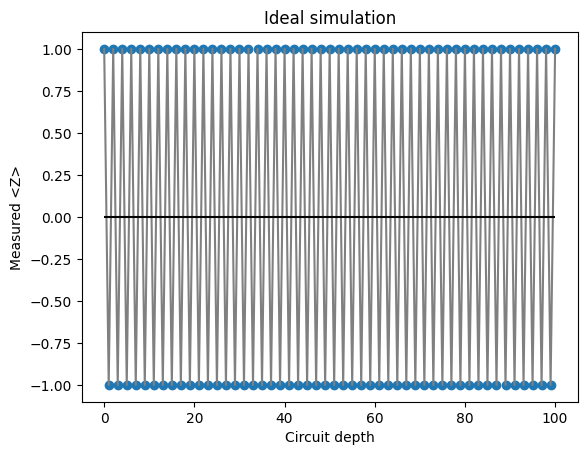

In [14]:
ideal_sampler = Sampler()
job_ideal = ideal_sampler.run(circuits)
result_ideal = job_ideal.result()
plt.title("Ideal simulation")
ds = list(range(MAX_DEPTH + 1))
plt.plot(
    ds,
    [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds],
    color="gray",
    linestyle="-",
)
plt.scatter(
    ds, [result_ideal[d].data.meas.expectation_values(["Z"]) for d in ds], marker="o"
)
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.xlabel("Circuit depth")
plt.ylabel("Measured <Z>")
plt.show()

### 2.7 演習問題

以下のコードを微調整することで、

* [ ] 25倍のショット数 (10\_000 shots) を試して、より滑らかなプロットが得られるようにします
* [ ] ノイズパラメータ(OVER\_ROTATION\_ANGLE、AMPLITUDE\_DAMPING\_PARAM、PREP0\_MEAS1、またはPREP1\_MEAS0)を変更し、プロットがどのように変化するかを確認します


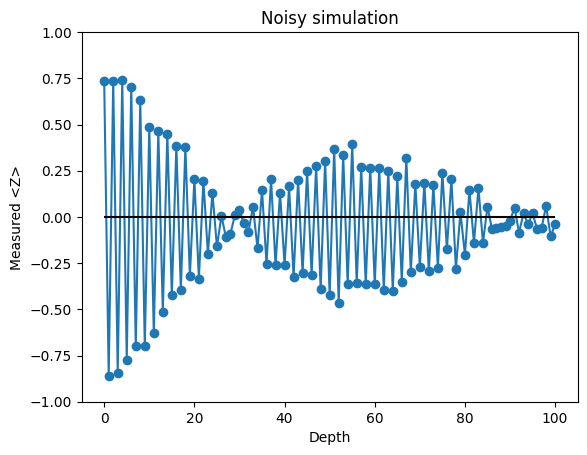

In [15]:
OVER_ROTATION_ANGLE = 0.05
coherent_error = coherent_unitary_error(RXGate(OVER_ROTATION_ANGLE).to_matrix())
AMPLITUDE_DAMPING_PARAM = 0.02  # in [0, 1] (0: no error)
incoherent_error = amplitude_damping_error(AMPLITUDE_DAMPING_PARAM)
PREP0_MEAS1 = 0.1  # P(1|0): 0を用意したが、1を測定してしまう確率
PREP1_MEAS0 = 0.05  # P(0|1): 1を用意したが、0を測定してしまう確率
readout_error = ReadoutError(
    [[1 - PREP0_MEAS1, PREP0_MEAS1], [PREP1_MEAS0, 1 - PREP1_MEAS0]]
)
noise_model = NoiseModel()
noise_model.add_quantum_error(coherent_error.compose(incoherent_error), "x", (0,))
noise_model.add_readout_error(readout_error, (0,))
options = {
    "backend_options": {"noise_model": noise_model},
}
noisy_sampler = Sampler(options=options)
job = noisy_sampler.run(circuits, shots=400)
result = job.result()
plt.title("Noisy simulation")
ds = list(range(MAX_DEPTH + 1))
plt.plot(
    ds,
    [result[d].data.meas.expectation_values(["Z"]) for d in ds],
    marker="o",
    linestyle="-",
)
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Depth")
plt.ylabel("Measured <Z>")
plt.show()

### 2.8 よりリアルなノイズシミュレーション

In [16]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

service = QiskitRuntimeService()
real_backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)  

In [17]:
real_backend

<IBMBackend('ibm_fez')>

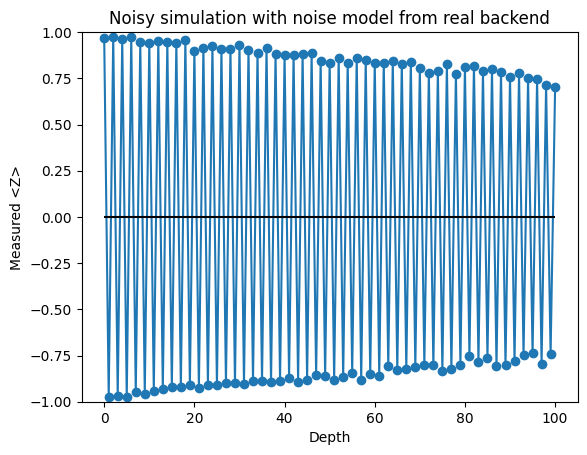

In [18]:
aer = AerSimulator.from_backend(real_backend)
noisy_sampler = Sampler(mode=aer)
job = noisy_sampler.run(circuits)
result = job.result()
plt.title("Noisy simulation with noise model from real backend")
ds = list(range(MAX_DEPTH + 1))
plt.plot(
    ds,
    [result[d].data.meas.expectation_values(["Z"]) for d in ds],
    marker="o",
    linestyle="-",
)
plt.hlines(0, xmin=0, xmax=MAX_DEPTH, colors="black")
plt.ylim(-1, 1)
plt.xlabel("Depth")
plt.ylabel("Measured <Z>")
plt.show()

## 3. エラー緩和を伴った実機による量子計算
このパートでは、Qiskit Estimatorを使用してエラー緩和された結果(期待値)を取得する方法を示します。
1次元イジングモデルの時間発展をシミュレートするために6量子ビットのトロッター化回路を使って、時間ステップ数に対してエラーがどのようにスケーリングされるかを確認します。


In [19]:
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)  
backend

<IBMBackend('ibm_fez')>

In [20]:
NUM_QUBITS = 6
NUM_TIME_STEPS = list(range(8))
RX_ANGLE = 0.1
RZZ_ANGLE = 0.1

### 3.1 回路の構築

In [21]:
# 異なるtime steps数で回路を構築する
circuits = []
for n_steps in NUM_TIME_STEPS:
    circ = QuantumCircuit(NUM_QUBITS)
    for i in range(n_steps):
        # rx layer
        for q in range(NUM_QUBITS):
            circ.rx(RX_ANGLE, q)
        # 1st rzz layer
        for q in range(1, NUM_QUBITS - 1, 2):
            circ.rzz(RZZ_ANGLE, q, q + 1)
        # 2nd rzz layer
        for q in range(0, NUM_QUBITS - 1, 2):
            circ.rzz(RZZ_ANGLE, q, q + 1)
    circ.barrier()  # need not to optimize the circuit
    # Uncompute stage
    for i in range(n_steps):
        for q in range(0, NUM_QUBITS - 1, 2):
            circ.rzz(-RZZ_ANGLE, q, q + 1)
        for q in range(1, NUM_QUBITS - 1, 2):
            circ.rzz(-RZZ_ANGLE, q, q + 1)
        for q in range(NUM_QUBITS):
            circ.rx(-RX_ANGLE, q)
    circuits.append(circ)

理想的な出力を事前に知るために、元の回路 $U$ が適用される第1段階と、それを逆にした $U^\dagger$ の第2段階から構成される compute-uncompute 回路を使用します。
このような回路の理想的な結果は、入力状態と同じ $|000000\rangle$ であり、これは、パウリ・オブザーバブルに対してありふれた期待値 (たとえば、$\langle IIIIIZ \rangle = 1$) を持つことに注意してください。


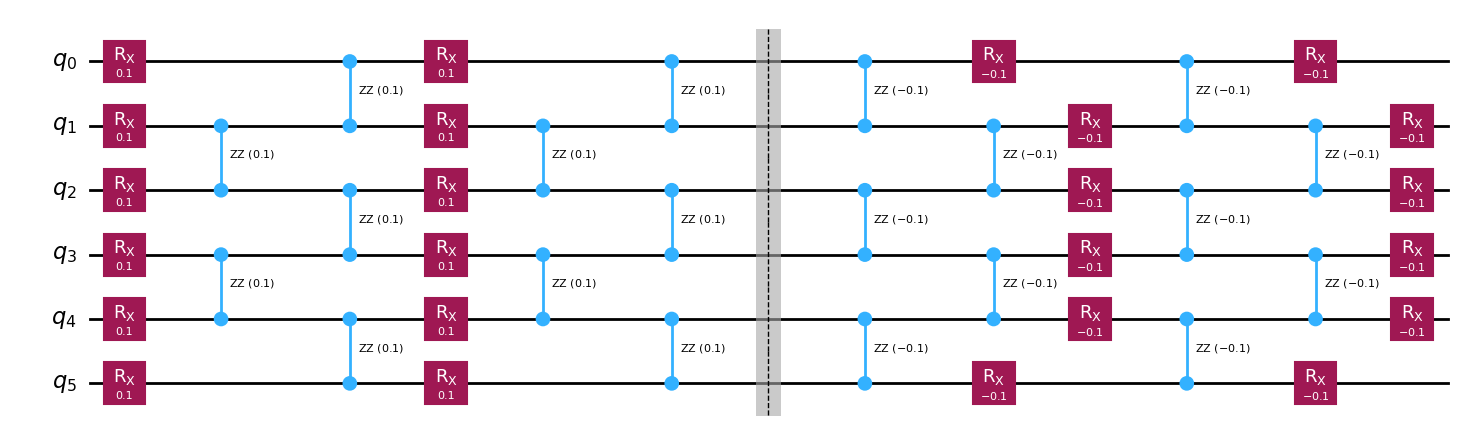

In [22]:
# タイムステップ2の回路を表示
circuits[2].draw(output="mpl")

注: 上のように、$k$ の時間ステップを持つ回路には、$4k$ 個のの 2 量子ビット・ゲート・レイヤーがあります。

In [23]:
obs = SparsePauliOp.from_sparse_list([("Z", [0], 1.0)], num_qubits=NUM_QUBITS)
obs

SparsePauliOp(['IIIIIZ'],
              coeffs=[1.+0.j])

### 3.2 回路をトランスパイル

`optimization_level=1` でバックエンドの回路をトランスパイルします。

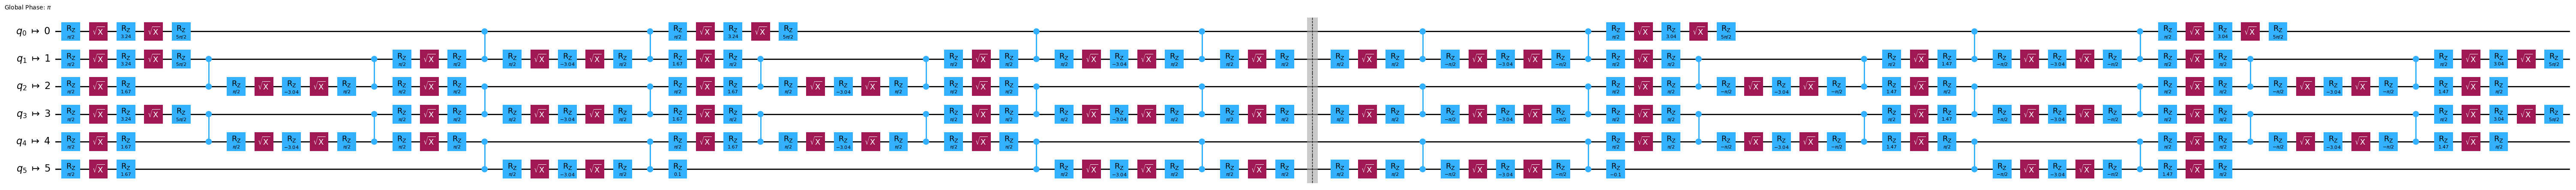

In [24]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuits = pm.run(circuits)
display(isa_circuits[2].draw("mpl", idle_wires=False, fold=-1))

### 3.3 Estimator を実行 (異なるresilience levelsを用いて)
resilience level ('estimator.options.resilience_level') を設定することは、Qiskit Estimator でエラー緩和を適用する最も簡単な方法です。Estimatorは、以下のresilience levelをサポートしています(2024/06/28時点)。詳細は、 [エラー緩和の設定](https://quantum.cloud.ibm.com/docs/en/guides/configure-error-mitigation)のガイドを参照してください。

| Resilience Level | 定義                                                                                            | 技術                                                    |
| ---------------- | ----------------------------------------------------------------------------------------------------- | ------------------------------------------------------------- |
| 0                | 緩和なし                                                                                         | なし                                                          |
| 1 \[デフォルト]     | 最小限の緩和コスト:読み出しエラーに関連するエラーを緩和                              | Twirled Readout Error eXtinction  (TREX) 測定トワリング |
| 2                | 程度の緩和コスト。通常、estimator のバイアスを低減しますが、ゼロバイアスであることは保証されません。| Level 1 +ゼロノイズ外挿(ZNE)およびゲートトワリング    |


In [25]:
from qiskit_ibm_runtime import Batch
from qiskit_ibm_runtime import EstimatorV2 as Estimator

jobs = []
job_ids = []
with Batch(backend=backend):
    for resilience_level in [0, 1, 2]:
        estimator = Estimator()
        estimator.options.resilience_level = resilience_level
        job = estimator.run(
            [(circ, obs.apply_layout(circ.layout)) for circ in isa_circuits]
        )
        job_ids.append(job.job_id())
        print(f"Job ID (rl={resilience_level}): {job.job_id()}")
        jobs.append(job)

Job ID (rl=0): d35mmbgitjus73f4gh8g
Job ID (rl=1): d35mmbsgenls73cc69pg
Job ID (rl=2): d35mmbo0sqis7396t40g


In [26]:
# check job status
for job in jobs:
    print(job.status())

DONE
DONE
DONE


In [27]:
# REPLACE WITH YOUR OWN JOB IDS
jobs = [service.job(job_id) for job_id in job_ids]

In [28]:
# Get results
results = [job.result() for job in jobs]

### 3.4 結果のプロット

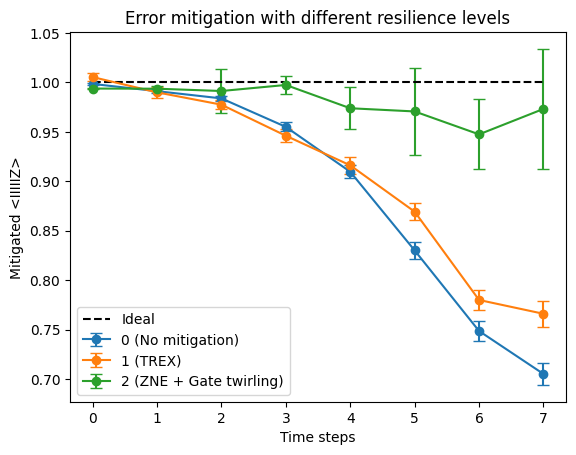

In [29]:
plt.title("Error mitigation with different resilience levels")
labels = ["0 (No mitigation)", "1 (TREX)", "2 (ZNE + Gate twirling)"]
steps = NUM_TIME_STEPS
for result, label in zip(results, labels):
    plt.errorbar(
        x=steps,
        y=[result[s].data.evs for s in steps],
        yerr=[result[s].data.stds for s in steps],
        marker="o",
        linestyle="-",
        capsize=4,
        label=label,
    )
plt.hlines(
    1.0, min(steps), max(steps), linestyle="dashed", label="Ideal", colors="black"
)
plt.xlabel("Time steps")
plt.ylabel("Mitigated <IIIIIZ>")
plt.legend()
plt.show()

## 4. (オプション) エラー緩和オプションのカスタマイズ
以下に示すように、オプションを使用してエラー緩和手法の適用をカスタマイズできます。

In [30]:
# TREX
estimator.options.twirling.enable_measure = True
estimator.options.twirling.num_randomizations = "auto"
estimator.options.twirling.shots_per_randomization = "auto"

# Gate twirling
estimator.options.twirling.enable_gates = True

# ZNE
estimator.options.resilience.zne_mitigation = True
estimator.options.resilience.zne.noise_factors = [1, 3, 5]
estimator.options.resilience.zne.extrapolator = ("exponential", "linear")

# Dynamical decoupling
estimator.options.dynamical_decoupling.enable = True  # Default: False
estimator.options.dynamical_decoupling.sequence_type = "XX"

# Other options
estimator.options.default_shots = 10_000

エラー緩和オプションの詳細については、次のガイドと API リファレンスを参照してください。

*   [エラー緩和の設定](https://quantum.cloud.ibm.com/docs/en/guides/configure-error-mitigation)
*   [オプションの概要](https://quantum.cloud.ibm.com/docs/en/guides/runtime-options-overview)
*   [EstimatorOptions](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/options-estimator-options)
*   [SamplerOptions](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/options-sampler-options)



© IBM Corp., 2017-2025